# Multidimensional Data Analysis

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student',
    password='dwdstudent2015',
    host='db.ipeirotis.org',
    port=3306,
    db='facebook')
engine_fb = create_engine(conn_string_fb)

## Lift and Log-odds: Facebook, Favorite Books, and Political views

Now let's do an analysis that examines book preferences and how they correlated with political leanings.

We will start by fetching the favorite books for students that declared themselves as Liberal or Conservative.

In [86]:
books = '''
SELECT B.Book, P.PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks B ON B.ProfileID = P.ProfileId  
WHERE PoliticalViews IS NOT NULL AND B.Book IS NOT NULL 
      AND (PoliticalViews = 'Liberal' OR PoliticalViews = 'Conservative')
AND B.Book IN (
    SELECT Book 
    FROM FavoriteBooks B JOIN Profiles P ON B.ProfileID = P.ProfileId  
    WHERE (P.PoliticalViews = 'Liberal' OR P.PoliticalViews = 'Conservative')
    GROUP BY Book HAVING COUNT(DISTINCT P.ProfileID)>10
)
GROUP BY B.Book, P.PoliticalViews;
'''

In [138]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

,Book,PoliticalViews,cnt
0,000 Leagues Under The Sea,Liberal,2
1,100 Strokes Of The Brush Before Bed,Liberal,2
2,100 Years Of Solitude,Conservative,3
3,100 Years Of Solitude,Liberal,55
4,1000 Places To See Before You Die,Liberal,2
5,1776,Conservative,2
6,1984,Conservative,32
7,1984,Liberal,286
8,1984 By George Orwell,Liberal,4
9,1984 George Orwell,Liberal,5


In [139]:
len(df_books)

2784

In [140]:
dfp = df_books.pivot_table(
    index='Book', 
    columns='PoliticalViews', 
    values='cnt')
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
000 Leagues Under The Sea,NaN,2.0
100 Strokes Of The Brush Before Bed,NaN,2.0
100 Years Of Solitude,3.0,55.0
1000 Places To See Before You Die,NaN,2.0
1776,2.0,NaN
1984,32.0,286.0
1984 By George Orwell,NaN,4.0
1984 George Orwell,NaN,5.0
1984 Orwell,NaN,6.0


Notice the `NaN` values for the entries where we had no users falling into that group. Since we will want to do calculations for these books as well, we will use the `fillna` command to fill these entries with a default value (in our case, 0)

In [141]:
# Fill the NaN entries with the value 0 
dfp = df_books.pivot_table(
    index='Book', 
    columns='PoliticalViews', 
    values='cnt').fillna(0)
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
000 Leagues Under The Sea,0.0,2.0
100 Strokes Of The Brush Before Bed,0.0,2.0
100 Years Of Solitude,3.0,55.0
1000 Places To See Before You Die,0.0,2.0
1776,2.0,0.0
1984,32.0,286.0
1984 By George Orwell,0.0,4.0
1984 George Orwell,0.0,5.0
1984 Orwell,0.0,6.0


**Normalization**: We now want to normalize the entries before proceeding further. Let's take a look at the breakdown of political views in the database.

In [142]:
polviews = '''
SELECT PoliticalViews, COUNT(*) AS cnt 
FROM facebook.Profiles
GROUP BY PoliticalViews
'''

In [143]:
df_polviews = pd.read_sql(polviews, con=engine_fb)
df_polviews

,PoliticalViews,cnt
0,None,11091
1,Apathetic,805
2,Conservative,936
3,Liberal,6461
4,Libertarian,325
5,Moderate,2898
6,Other,824
7,Very Conservative,167
8,Very Liberal,2277


In [144]:
df_polviews.set_index('PoliticalViews', inplace=True)
df_polviews

,cnt
PoliticalViews,
NaN,11091
Apathetic,805
Conservative,936
Liberal,6461
Libertarian,325
Moderate,2898
Other,824
Very Conservative,167
Very Liberal,2277


In [145]:
liberals = df_polviews.at['Liberal','cnt']
liberals

6461

In [146]:
conservatives = df_polviews.at['Conservative','cnt']
conservatives

936

Since we have many more conservatives than liberals, let's create a new column that calculates the **percentage** of liberal and conservative students that liked each book. We add the `+1` in the numerator to avoid division by zero later on. _As practice, try to fetch the values 936 and 6461 directly from the database, and automate the calculation._

In [147]:
dfp["Liberal_perc"] = 100*(dfp["Liberal"] +1)  / liberals
dfp["Conservative_perc"] = 100*(dfp["Conservative"] +1)  / conservatives

In [148]:
dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc
Book,,,,
000 Leagues Under The Sea,0.0,2.0,0.046432,0.106838
100 Strokes Of The Brush Before Bed,0.0,2.0,0.046432,0.106838
100 Years Of Solitude,3.0,55.0,0.866739,0.427350
1000 Places To See Before You Die,0.0,2.0,0.046432,0.106838
1776,2.0,0.0,0.015477,0.320513
1984,32.0,286.0,4.442037,3.525641
1984 By George Orwell,0.0,4.0,0.077387,0.106838
1984 George Orwell,0.0,5.0,0.092865,0.106838
1984 Orwell,0.0,6.0,0.108342,0.106838


In [149]:
dfp.loc['Harry Potter']

PoliticalViews
Conservative          66.000000
Liberal              555.000000
Liberal_perc           8.605479
Conservative_perc      7.158120
Name: Harry Potter, dtype: float64

#### Lift

Now that we have the normalized values, we can compute the **lift** for each book. The lift is the ratio between the percentage of liberals and the percentage of convervatives. A book with `lift==1` will be equally read by both conservatives and liberals. Books that have lifts significantly higher or lower than 1, reveal preferences to be read by one side of the political spectrum.

In [150]:
dfp["lift_liberal"] = dfp["Liberal_perc"] / dfp["Conservative_perc"]
dfp["lift_conservative"] = dfp["Conservative_perc"]  / dfp["Liberal_perc"]

In [151]:
dfp = dfp[ ['lift_liberal', 'lift_conservative', 'Liberal_perc', 'Conservative_perc', 'Liberal', 'Conservative'] ]

In [152]:
dfp.head(10)

PoliticalViews,lift_liberal,lift_conservative,Liberal_perc,Conservative_perc,Liberal,Conservative
Book,,,,,,
000 Leagues Under The Sea,0.434608,2.300926,0.046432,0.106838,2.0,0.0
100 Strokes Of The Brush Before Bed,0.434608,2.300926,0.046432,0.106838,2.0,0.0
100 Years Of Solitude,2.028169,0.493056,0.866739,0.427350,55.0,3.0
1000 Places To See Before You Die,0.434608,2.300926,0.046432,0.106838,2.0,0.0
1776,0.048290,20.708333,0.015477,0.320513,0.0,2.0
1984,1.259923,0.793699,4.442037,3.525641,286.0,32.0
1984 By George Orwell,0.724346,1.380556,0.077387,0.106838,4.0,0.0
1984 George Orwell,0.869215,1.150463,0.092865,0.106838,5.0,0.0
1984 Orwell,1.014085,0.986111,0.108342,0.106838,6.0,0.0


#### Log-odds

One common tranformation is to take the `log` of the lift. We call this metric **log odds**. In that case, the `lift==1` corresponds to a `log_odds` of 0. Negative values indicate negative association, and positive values indicate positive association. A nice property of log-odds is that they are **additive**, which means that summing up log-odds makes (mathematical) sense, under some reasonably general conditions. (The details are beyond the scope of this course, but you can learn more in the data mining class.)

In [153]:
import numpy as np
dfp["log_odds_liberal"]      =  np.log(dfp["lift_liberal"])
dfp["log_odds_conservative"] =  np.log(dfp["lift_conservative"])

In [154]:
dfp[ ['log_odds_liberal', 'log_odds_conservative', 'lift_liberal', 'lift_conservative', 'Liberal', 'Conservative'] ]

PoliticalViews,log_odds_liberal,log_odds_conservative,lift_liberal,lift_conservative,Liberal,Conservative
Book,,,,,,
000 Leagues Under The Sea,-0.833312,0.833312,0.434608,2.300926,2.0,0.0
100 Strokes Of The Brush Before Bed,-0.833312,0.833312,0.434608,2.300926,2.0,0.0
100 Years Of Solitude,0.707133,-0.707133,2.028169,0.493056,55.0,3.0
1000 Places To See Before You Die,-0.833312,0.833312,0.434608,2.300926,2.0,0.0
1776,-3.030536,3.030536,0.048290,20.708333,0.0,2.0
1984,0.231051,-0.231051,1.259923,0.793699,286.0,32.0
1984 By George Orwell,-0.322486,0.322486,0.724346,1.380556,4.0,0.0
1984 George Orwell,-0.140164,0.140164,0.869215,1.150463,5.0,0.0
1984 Orwell,0.013986,-0.013986,1.014085,0.986111,6.0,0.0


In [155]:
show_columns = ["lift_liberal", "log_odds_liberal", "lift_conservative", "log_odds_conservative", "Liberal", "Conservative"]

In [156]:
liberal_books = (dfp[show_columns]
                 .sort_values("lift_liberal", ascending=False)
                 .head(11)
                )
liberal_books

PoliticalViews,lift_liberal,log_odds_liberal,lift_conservative,log_odds_conservative,Liberal,Conservative
Book,,,,,,
The Little Prince,11.734406,2.462525,0.085219,-2.462525,80.0,0.0
The Kite Runner,9.126761,2.211211,0.109568,-2.211211,62.0,0.0
The Hours,8.547284,2.145614,0.116996,-2.145614,58.0,0.0
Fear And Loathing In Las Vegas,8.402414,2.128519,0.119013,-2.128519,57.0,0.0
The Bluest Eye,7.533199,2.019320,0.132746,-2.019320,51.0,0.0
Love In The Time Of Cholera,7.388330,1.999902,0.135349,-1.999902,50.0,0.0
The Phantom Tollbooth,6.953722,1.939277,0.143808,-1.939277,47.0,0.0
Angels In America,6.808853,1.918224,0.146868,-1.918224,46.0,0.0
Beloved,6.374245,1.852266,0.156881,-1.852266,43.0,0.0


In [157]:
conservative_books = (dfp[show_columns]
                      .sort_values("lift_conservative", ascending=False)
                      .head(11)
                     )
conservative_books

PoliticalViews,lift_liberal,log_odds_liberal,lift_conservative,log_odds_conservative,Liberal,Conservative
Book,,,,,,
Blue Like Jazz,0.018109,-4.011365,55.222222,4.011365,0.0,7.0
How To Talk To A Liberal If You Must,0.028974,-3.541362,34.513889,3.541362,0.0,4.0
Red Storm Rising,0.036217,-3.318218,27.611111,3.318218,0.0,3.0
The Case For Faith,0.036217,-3.318218,27.611111,3.318218,0.0,3.0
Wsj,0.036217,-3.318218,27.611111,3.318218,0.0,3.0
Good To Great,0.036217,-3.318218,27.611111,3.318218,0.0,3.0
Liar S Poker,0.045748,-3.084603,21.858796,3.084603,5.0,18.0
The Picture Of Dorian Gray Oscar Wilde,0.048290,-3.030536,20.708333,3.030536,0.0,2.0
Confessions,0.048290,-3.030536,20.708333,3.030536,0.0,2.0


Text(0.5, 0, 'Lift for Conservatives')

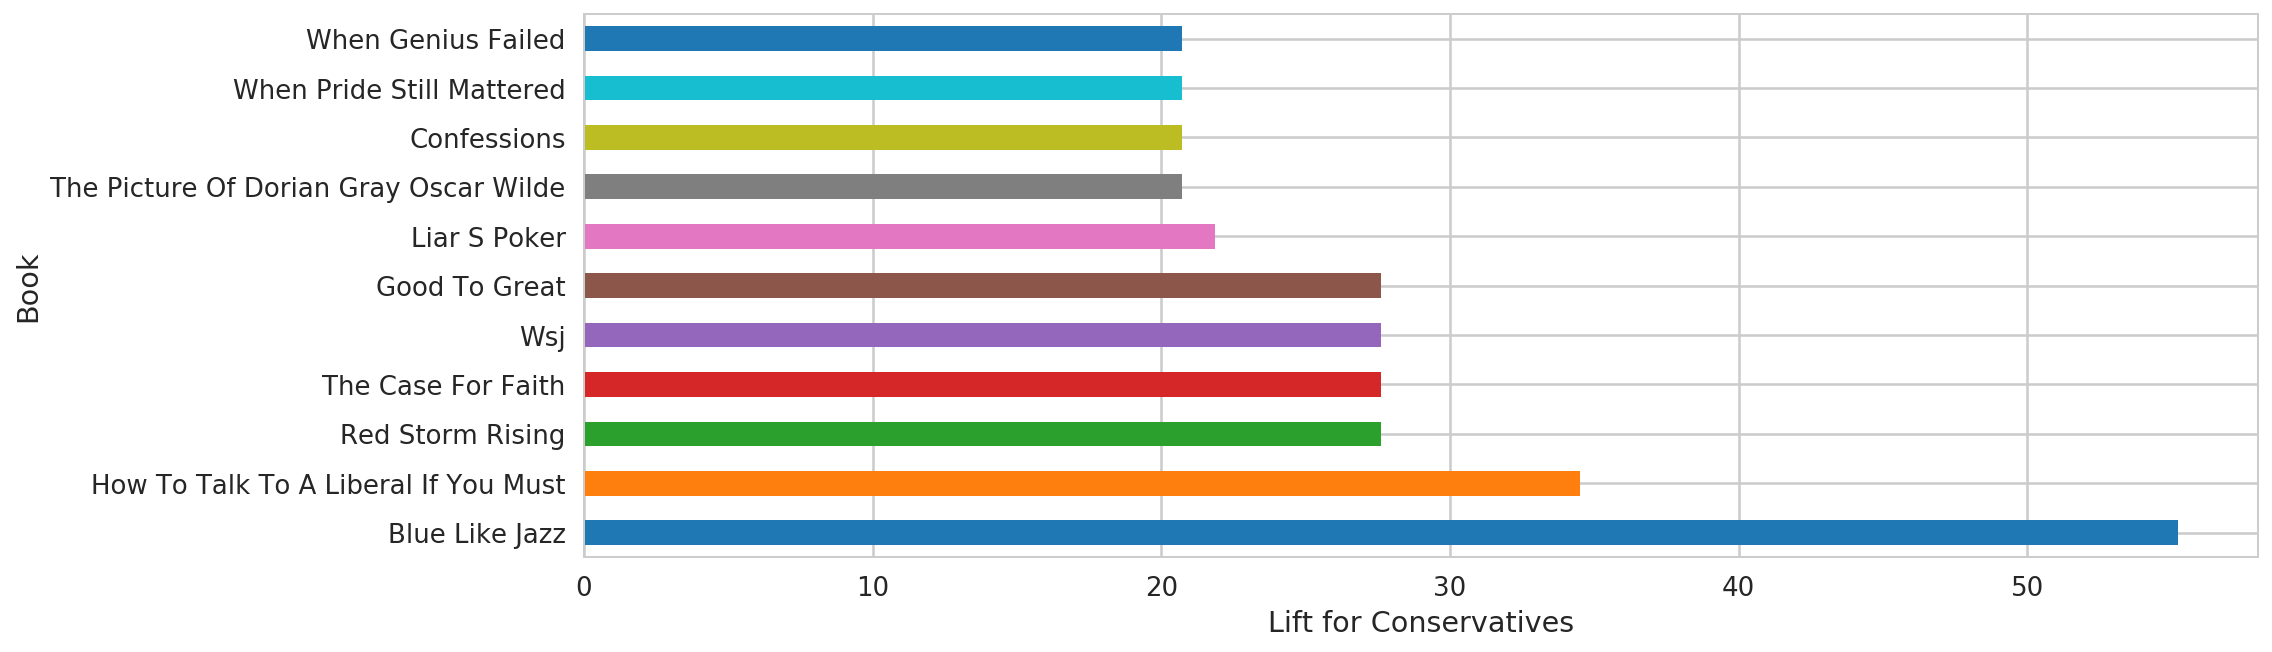

In [158]:
plot = conservative_books.lift_conservative.plot(kind='barh', figsize=(15,5))
plot.set_xlabel("Lift for Conservatives")

Text(0.5, 0, 'Lift for Liberals')

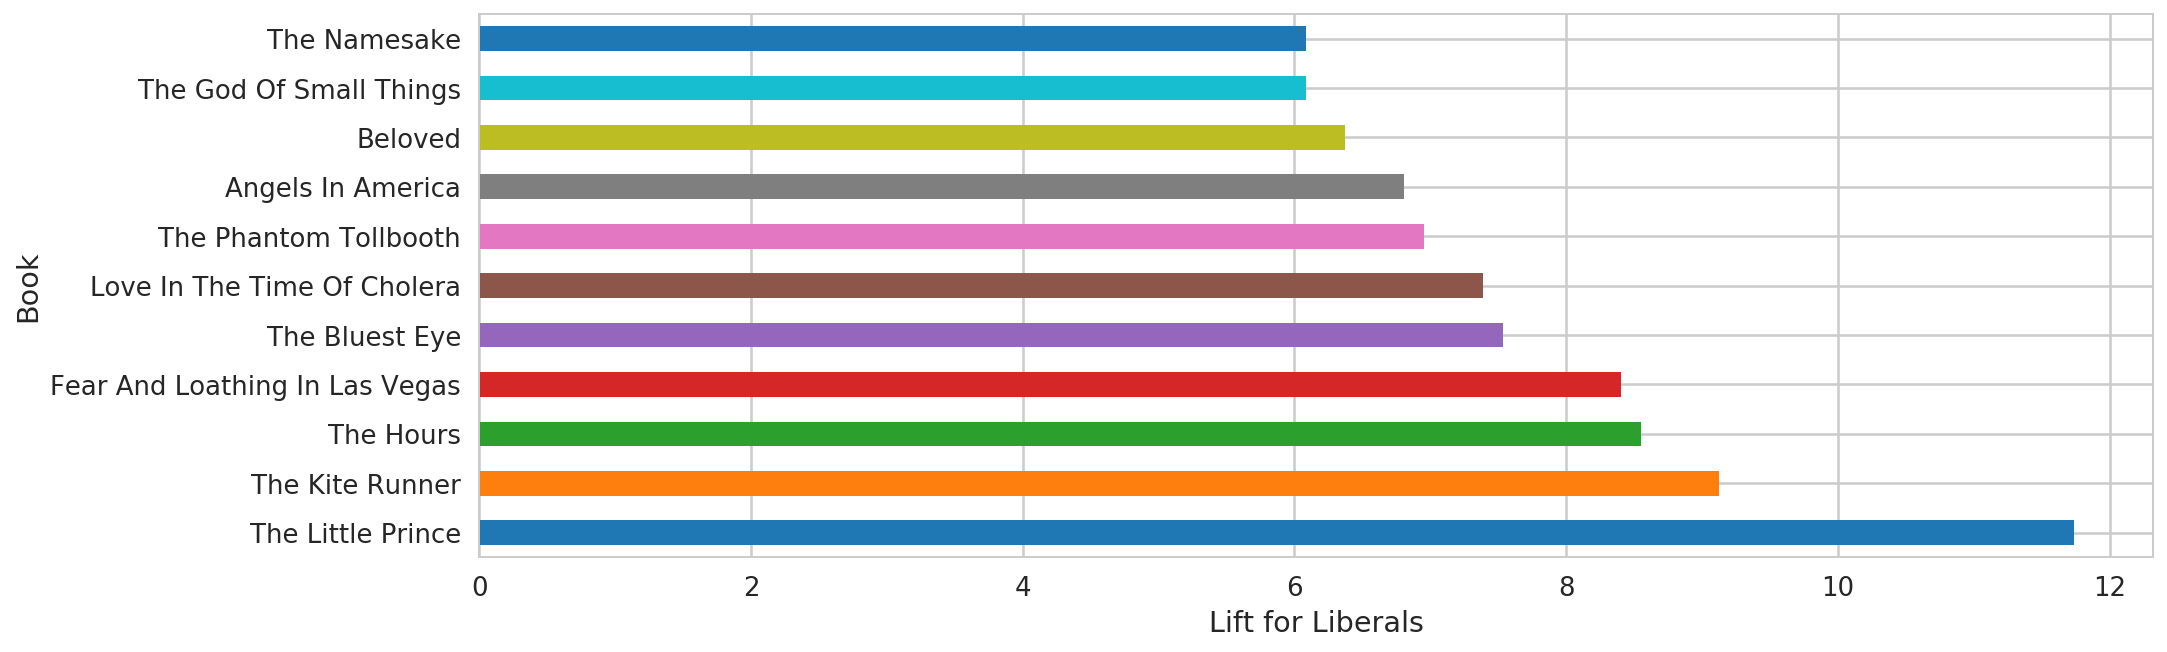

In [159]:
plot = liberal_books.lift_liberal.plot(kind='barh', figsize=(15,5))
plot.set_xlabel("Lift for Liberals")

#### Exercise

We have seen how to compute the log-odds between liberal-conservative for each book. Given this information, we can try to estimate political leanings of students. You can do this by summing the log-odds of their favorite books. 

Steps: 
1. Create a table with the log-odds of the books. 
2. Join the table with the log-odds with the book preferences table.
3. Sum the log-odds score for each student.

Evaluation:
* You have students that have declared their political preferences as Liberal, Conservative, Very Liberal, Very Conservative. Examine the scores for these students, to check how well this technique works. The simplest way is to compute the average (mean) log-odds for students that fall into the different groups. Alternatively, you can try to plot the full distribution of scores.
* Calculate a score for each student that did not declare a political view but has listed Favorite Books.

Notes: 
* You can do the work in MySQL or in Pandas. If you decide to work purely in Pandas, the [`merge`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html#pandas.DataFrame.merge) command allows you to perform joins between dataframes, in way similar to SQL.

,log_odds_liberal
PoliticalViews,
Apathetic,0.305186
Conservative,-1.712536
Liberal,0.696511
Libertarian,0.340519
Moderate,0.064876
Other,0.248054
Very Conservative,-0.847399
Very Liberal,1.075680
